 # Dataset 

### Disclaimer!!!
### Чрезмерное употребление алкоголя вредит вашему здоровью! (Отношусь к нему негативно, просто интересный и уникальный датасет :) ) 

Мной были выбраны два датасета для решения практических задач:
 - __Для классификации__ датасет качества красного вина - предсказание качества вина по его химическим свойствам 
 - __Для регрессии__  датасет спроса на прокат велосипедов - предсказание количества арендованных велосипедов по погодным условиям и времени

Эти задачи имеют практическое применение:

 - Определение качества вина помогает виноделам контролировать процесс производства
 - Прогнозирование спроса на велосипеды помогает оптимизировать логистику системы проката

# **Выбор метрик**

Для __классификации__ я выбираю две метрики: accuracy, для общей оценки моделей, и f1, для оценки общей классификации.  
Для __регрессии__ я выбрал три метрики: MAE, для оценивания средней величины отклонений, MSE, для оценивания крупных ошибок, R2, для просмотра качества модели.

In [189]:
# %pip install kagglehub

# import kagglehub

# path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")

# print("Path to dataset files:", path)

# Алгоритм KNN

## Задача классификации

In [190]:
# скачаем нужные либы
# %pip install pandas
# %pip install sklearn
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

#### Загрузка и подготовка данных для классификации

In [191]:
path = 'winequality-red.csv'
data_class = pd.read_csv(path)

print("Первые 5 строк датасета для классификации:")
print(data_class.head())
print(f"\nРазмер датасета: {data_class.shape}")


Первые 5 строк датасета для классификации:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  

#### Создаем целевую переменную для классификации (качество вина)

In [192]:
print("\nРаспределение исходного качества вина:")
print(data_class['quality'].value_counts().sort_index())


Распределение исходного качества вина:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


#### Создаем бинарную классификацию: хорошее вино (quality >= 6) и плохое вино (quality < 6)

In [193]:
data_class['wine_quality'] = data_class['quality'].apply(lambda x: 'good' if x >= 6 else 'bad')
data_class = data_class.drop('quality', axis=1)

print("\nРаспределение после преобразования:")
print(data_class['wine_quality'].value_counts())


Распределение после преобразования:
wine_quality
good    855
bad     744
Name: count, dtype: int64


#### Визуализация распределения целевой переменной

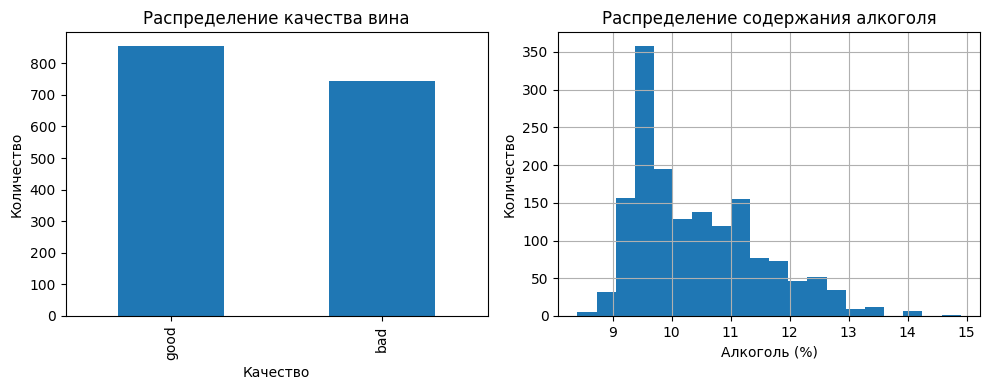

In [194]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
data_class['wine_quality'].value_counts().plot(kind='bar')
plt.title('Распределение качества вина')
plt.xlabel('Качество')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
data_class['alcohol'].hist(bins=20)
plt.title('Распределение содержания алкоголя')
plt.xlabel('Алкоголь (%)')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

#### Разделим датасет на тестовую и обучающую выборки

In [195]:
X = data_class.drop('wine_quality', axis=1)
y = data_class['wine_quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (1279, 11), Размер тестовой выборки: (320, 11)


#### Применим встроенный KNN для классификации

In [196]:
knn_baseline = KNeighborsClassifier()
knn_baseline.fit(X_train, y_train)

y_pred = knn_baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Бейзлайн KNN:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


Бейзлайн KNN:
Accuracy: 0.7344
F1-Score: 0.7344


#### Подберем гиперпараметры для улучшения бейзлайна

In [197]:
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

best_knn = grid_search.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}


#### Проведем обучение улучшенной модели и посчитаем метрики

In [198]:
y_pred_best = best_knn.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("Улучшенный бейзлайн:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Улучшенный бейзлайн:
Accuracy: 0.8031
F1-Score: 0.8026

Classification Report:
              precision    recall  f1-score   support

         bad       0.81      0.76      0.78       149
        good       0.80      0.84      0.82       171

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.80      0.80      0.80       320



#### Реализуем свою имплементацию алгоритма

In [199]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class CustomKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

custom_knn = CustomKNN(k=best_params['n_neighbors'])
custom_knn.fit(X_train, y_train)

y_pred_custom = custom_knn.predict(X_test)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='weighted')

print("Реализация Custom KNN:")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")


Реализация Custom KNN:
Accuracy: 0.7500
F1-Score: 0.7502


## Задача регрессии

In [200]:
# Скачиваем нужные либы
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# загружаем данные
path = 'hour.csv'
data_reg = pd.read_csv(path)

print("Первые 5 строк датасета для регрессии:")
print(data_reg.head())
print(f"\nРазмер датасета: {data_reg.shape}")

Первые 5 строк датасета для регрессии:
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  

Размер датасета: (17379, 17)


#### Визуализация распределения целевой переменной

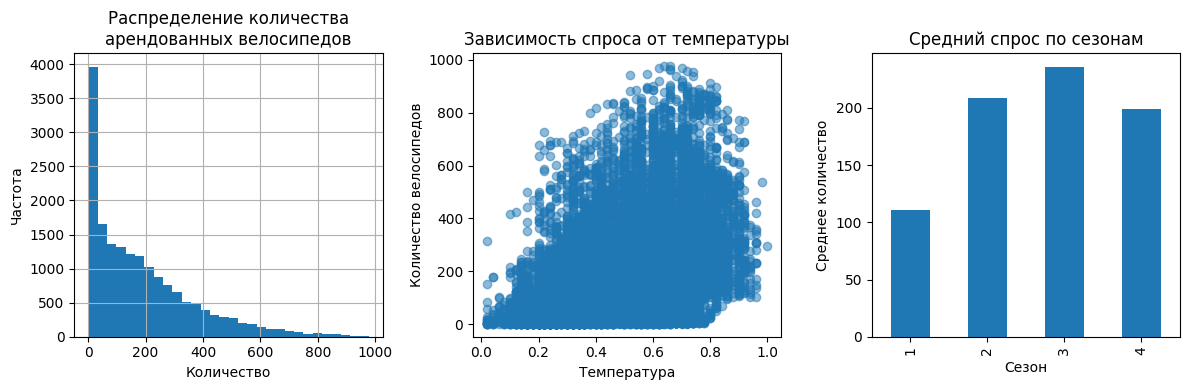

In [201]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
data_reg['cnt'].hist(bins=30)
plt.title('Распределение количества\nарендованных велосипедов')
plt.xlabel('Количество')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.scatter(data_reg['temp'], data_reg['cnt'], alpha=0.5)
plt.title('Зависимость спроса от температуры')
plt.xlabel('Температура')
plt.ylabel('Количество велосипедов')

plt.subplot(1, 3, 3)
data_reg.groupby('season')['cnt'].mean().plot(kind='bar')
plt.title('Средний спрос по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Среднее количество')

plt.tight_layout()
plt.show()

# В сезонах: 1 - зима, 2 - весна, 3 - лето, 4 - осень
# А температура считается, как нормализованная температура в Цельсиях. Значение выводится по формуле: (t - t_min)/(t_max - t_min),
# где t_min = -8, t_max = +39 

#### Разделим данные на тестовую и обучающую выборку

In [202]:
# Разделим данные на тестовую и обучающую выборку
X = data_reg.drop('cnt', axis=1)
y = data_reg['cnt']

# на этом этапе словил ошибку, что дата была, как строка, удалим его

# Проверим типы данных
print("Типы данных в признаках:")
print(X.dtypes)

# Найдем нечисловые столбцы
non_numeric_columns = X.select_dtypes(include=['object', 'datetime']).columns
print(f"\nНечисловые столбцы: {list(non_numeric_columns)}")

# Удалим нечисловые столбцы или преобразуем их
if len(non_numeric_columns) > 0:
    print("Удаляем нечисловые столбцы...")
    X = X.drop(non_numeric_columns, axis=1)

# Также проверим на наличие пропущенных значений
print(f"\nПропущенные значения: {X.isnull().sum().sum()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nРазмер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")
print(f"Используемые признаки: {list(X.columns)}")

# Масштабирование признаков
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

Типы данных в признаках:
instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

Нечисловые столбцы: ['dteday']
Удаляем нечисловые столбцы...

Пропущенные значения: 0

Размер обучающей выборки: (13903, 15), Размер тестовой выборки: (3476, 15)
Используемые признаки: ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']


#### Масштабирование признаков

In [203]:
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

#### Обучение бейзлайна и оценка модели

In [204]:
knn_reg_baseline = KNeighborsRegressor(n_neighbors=5)
knn_reg_baseline.fit(X_train_scaled, y_train)
y_pred_reg = knn_reg_baseline.predict(X_test_scaled)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Бейзлайн KNN регрессия:")
mae_baseline, mse_baseline, r2_baseline = evaluate_model(y_test, y_pred_reg)
print(f"MAE: {mae_baseline:.4f}, MSE: {mse_baseline:.4f}, R²: {r2_baseline:.4f}")


Бейзлайн KNN регрессия:
MAE: 25.6360, MSE: 1184.6090, R²: 0.9626


#### Подберем гиперпараметры для улучшения модели

In [205]:
param_grid_reg = {"n_neighbors": range(1, 20)}

grid_reg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_reg,
    cv=5,
    scoring="r2",
    verbose=1,
)
grid_reg.fit(X_train_scaled, y_train)

best_k_reg = grid_reg.best_params_["n_neighbors"]
print(f"Лучший k для регрессии: {best_k_reg}")

# Обучим модели с подобранными гиперпараметрами
knn_reg_optimized = KNeighborsRegressor(n_neighbors=best_k_reg)
knn_reg_optimized.fit(X_train_scaled, y_train)
y_pred_reg_optimized = knn_reg_optimized.predict(X_test_scaled)

print("Улучшенная KNN регрессия:")
mae_optimized, mse_optimized, r2_optimized = evaluate_model(y_test, y_pred_reg_optimized)
print(f"MAE: {mae_optimized:.4f}, MSE: {mse_optimized:.4f}, R²: {r2_optimized:.4f}")


Fitting 5 folds for each of 19 candidates, totalling 95 fits
Лучший k для регрессии: 6
Улучшенная KNN регрессия:
MAE: 25.8994, MSE: 1190.9391, R²: 0.9624


#### Делаем свою реализацию алгоритма для регрессии

In [206]:
class CustomKNNRegressor:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return np.mean(k_nearest_labels)

custom_knn_reg = CustomKNNRegressor(k=best_k_reg)
custom_knn_reg.fit(X_train_scaled, y_train)
y_pred_custom_reg = custom_knn_reg.predict(X_test_scaled)

mae_custom, mse_custom, r2_custom = evaluate_model(y_test, y_pred_custom_reg)

print("Custom KNN регрессия:")
print(f"MAE: {mae_custom:.4f}, MSE: {mse_custom:.4f}, R²: {r2_custom:.4f}")


Custom KNN регрессия:
MAE: 25.8994, MSE: 1190.9391, R²: 0.9624


#### Сравнение всех полученных результатов

In [207]:
print("\nСравнение результатов для задачи регрессии:")
print(f"Бейзлайн MAE: {mae_baseline:.4f}, Улучшенный MAE: {mae_optimized:.4f}, Custom KNN MAE: {mae_custom:.4f}")
print(f"Бейзлайн MSE: {mse_baseline:.4f}, Улучшенный MSE: {mse_optimized:.4f}, Custom KNN MSE: {mse_custom:.4f}")
print(f"Бейзлайн R²: {r2_baseline:.4f}, Улучшенный R²: {r2_optimized:.4f}, Custom KNN R²: {r2_custom:.4f}")


Сравнение результатов для задачи регрессии:
Бейзлайн MAE: 25.6360, Улучшенный MAE: 25.8994, Custom KNN MAE: 25.8994
Бейзлайн MSE: 1184.6090, Улучшенный MSE: 1190.9391, Custom KNN MSE: 1190.9391
Бейзлайн R²: 0.9626, Улучшенный R²: 0.9624, Custom KNN R²: 0.9624
